In [263]:
# import required libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from IPython.display import display
from IPython.display import Image as IMG

In [772]:
# helper functions
def generate_kernel(shape):
    kernel = np.random.randn(*shape)
    
    return kernel

def reshape(kernel):
    ch, h, w = kernel.shape
    out = np.zeros((h, w, ch))
    
    for i in range(ch):
        for j in range(h):
            for k in range(w):
                out[j,k,i] = kernel[i,j,k]
    
    return out

def display_image(image):
    plt.imshow(image)
    plt.axis('off')
    
def relu(x):
    return np.maximum(0, x)

def prelu(x, num_channel=3):
    alpha = np.random.rand(num_channel, 1, 1)
    res = np.maximum(0, x) + alpha * np.minimum(0, x)
    return res

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def max_pooling(x):
    return np.max(x, axis=(0,1))

def average_pooling(x):
    return np.mean(x, axis=(0,1))

## Question 1

**Convolution function:** It accepts an image input, a filter kernel, stride, padding and the nonlinear function. The function must convolve the input image (after padding if specified) with the
kernel (at the specified stride size) and generate an output activation after applying the specified
non-linearity. Verify with the standard options for the non-linear activation functions - sigmoid,
tanh, ReLU, Parametric ReLU (PReLU). Display the input image (e.g. small image of the IITH
logo), the filter kernel and the output activation map. Ensure that your function can accept
multi-channel input and a corresponding kernel volume. 

In [773]:
def convolution(image, kernel, stride=1, padding=0, activation=lambda x: x):
    # Get dimensions of input image and kernel
    n_H, n_W, ch = image.shape
    ch, f_H, f_W = kernel.shape
    
    # Calculate output dimensions
    n_H_out = int((n_H + 2*padding - f_H) / stride) + 1
    n_W_out = int((n_W + 2*padding - f_W) / stride) + 1
    
    # Add padding to input image
    image_padded = np.pad(image, padding, mode='constant')
    
    # Initialize output activation map
    output = np.zeros((n_H_out, n_W_out))
    kernel = reshape(kernel)
    
    # Loop over output activation map
    for h in range(n_H_out):
        for w in range(n_W_out):
            # Find the corners of the current "slice" of the input image
            vert_start = h * stride
            vert_end = vert_start + f_H
            horiz_start = w * stride
            horiz_end = horiz_start + f_W
            
            # Extract the slice of the input image
            image_slice = image_padded[vert_start:vert_end, horiz_start:horiz_end]
            
            # Perform element-wise multiplication between the slice and the kernel
            output[h, w] = np.sum(image_slice * kernel)
    
    # Apply activation function
    output = activation(output)
    
    return output

In [774]:
img = Image.open('rose-image.jpg')
input_img = np.array(img)

In [775]:
input_img.shape

(1272, 1920, 3)

In [776]:
filter_kernel = np.array(
[[[30, -1, 30], [-1, 40, -1], [30, -1, 30]],
 [[-1, 40, -1], [-1, 40, -1], [-1, 40, -1]],
 [[30, -1, 30], [-1, 40, -1], [30, -1, 30]]])

In [777]:
filter_kernel.shape

(3, 3, 3)

In [778]:
activation_map = convolution(input_img, filter_kernel, stride=2, padding=0, activation=relu)
activation_map.shape

(635, 959)

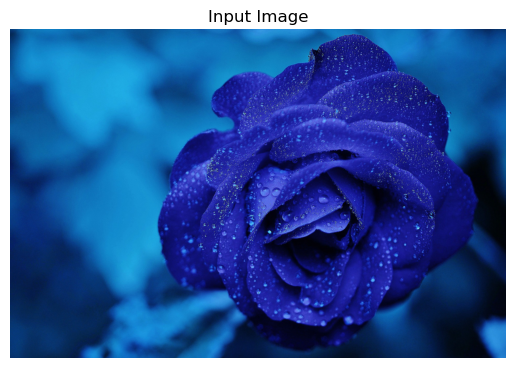

In [779]:
# Display the input image
plt.imshow(input_img)
plt.axis('off')
plt.title("Input Image");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


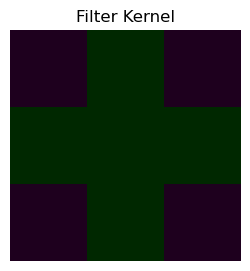

In [780]:
# Display the filter kernel
plt.figure(figsize=(3,3))
plt.imshow(filter_kernel)
plt.axis('off')
plt.title("Filter Kernel");

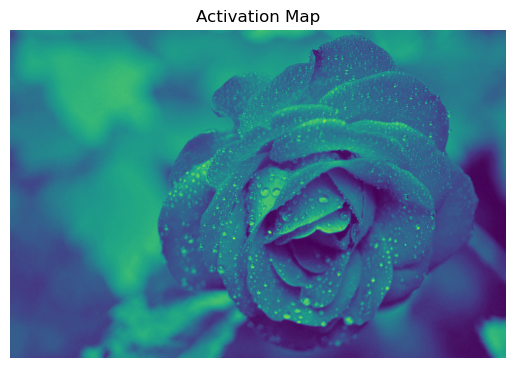

In [781]:
# Display output activation map
plt.imshow(activation_map)
plt.axis('off')
plt.title("Activation Map");

## Question 2

**Pooling function:** It accepts as input the activation map output from the convolution function,
a pooling function, and stride. The function must output the appropriately pooled activation map.
Display the input activation map and the pooled output.

In [782]:
def pooling(image, pool_fn=np.max, stride=1):
    # Get dimensions of activation map
    n_H, n_W = image.shape
    
    # Calculate output dimensions
    n_H_out = int((n_H - 1) / stride) + 1
    n_W_out = int((n_W - 1) / stride) + 1
    
    # Initialize output pooled activation map
    pooled_map = np.zeros((n_H_out, n_W_out))
    
    # Loop over output pooled activation map
    for h in range(n_H_out):
        for w in range(n_W_out):
            # Find the corners of the current "slice" of the activation map
            vert_start = h * stride
            vert_end = vert_start + stride
            horiz_start = w * stride
            horiz_end = horiz_start + stride
            
            # Extract the slice of the activation map
            activation_slice = image[vert_start:vert_end, horiz_start:horiz_end]
            
            # Apply the pooling function to the slice
            pooled_map[h, w] = pool_fn(activation_slice)
    
    return pooled_map

In [783]:
pooled_output = pooling(activation_map, stride=3)

In [784]:
activation_map.shape

(635, 959)

In [785]:
pooled_output.shape

(212, 320)

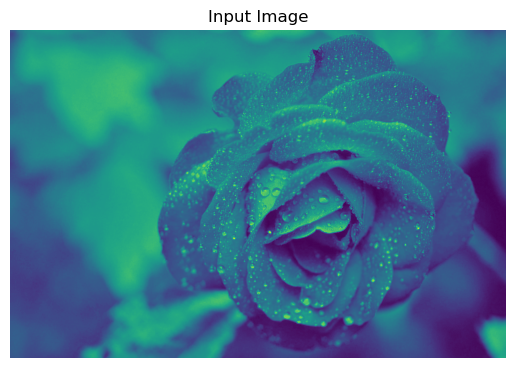

In [786]:
# Display the input image
plt.imshow(activation_map)
plt.axis('off')
plt.title("Input Image");

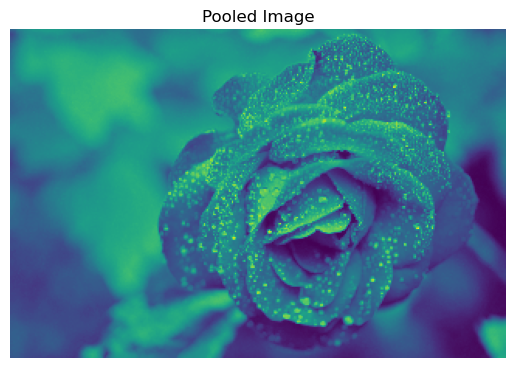

In [787]:
# Display pooled output
plt.imshow(pooled_output)
plt.axis('off')
plt.title("Pooled Image");

## Question 3

**Convolution layer function:** It accepts as input a volume (image or activation maps), number of
filters, kernel dimensions, stride, padding and the non-linear function. The function must convolve
the input volume (after padding if specified) with each of the kernels (at the specified stride size)
and generates an output activation volume after applying the specified non-linearity. Display the
input image or activation maps, the filter kernels and the output activation maps. Verify that the
output of this function does indeed have the expected size (W × H × C) as discussed in class.

In [788]:
def convolutional_layer(image, kernel, stride=1, padding=0, activation=lambda x: x):
    # Get dimensions of input image and kernel
    n_H, n_W, ch = image.shape
    num_filters, ch, f_H, f_W = kernel.shape
    
    # Calculate output dimensions
    n_H_out = int((n_H + 2*padding - f_H) / stride) + 1
    n_W_out = int((n_W + 2*padding - f_W) / stride) + 1
    
    # Add padding to input image
    image_padded = np.pad(image, padding, mode='constant')
    
    # Initialize output activation map
    output = np.zeros((n_H_out, n_W_out, num_filters))
    
    # Loop over the filters
    for f in range(num_filters):
        conv = convolution(image, kernel[f], stride=stride, padding=padding, activation=activation)
        output[:,:,f] = conv
    
    return output

In [789]:
input_img.shape

(1272, 1920, 3)

In [790]:
filter_kernels = np.array([
[[[30, -1, 30], [-1, 40, -1], [30, -1, 30]],
 [[-1, 40, -1], [-1, 40, -1], [-1, 40, -1]],
 [[30, -1, 30], [-1, 40, -1], [30, -1, 30]]],
[[[-1, -1, -1], [-1, -1, -1], [-1, -1, -1]],
 [[-1, 80, -1], [-1, 80, -1], [-1, 80, -1]],
 [[-1, -1, -1], [-1, -1, -1], [-1, -1, -1]]],
[[[.1, .2, .1], [.2, .4, .2], [.1, .2, .1]],
 [[.1, .2, .1], [.2, .4, .2], [.1, .2, .1]],
 [[.1, .2, .1], [.2, .4, .2], [.1, .2, .1]]]
])

In [791]:
filter_kernels.shape

(3, 3, 3, 3)

In [792]:
activation_vol = convolutional_layer(input_img, filter_kernels, stride=2, padding=0, activation=relu)
activation_vol.shape

(635, 959, 3)

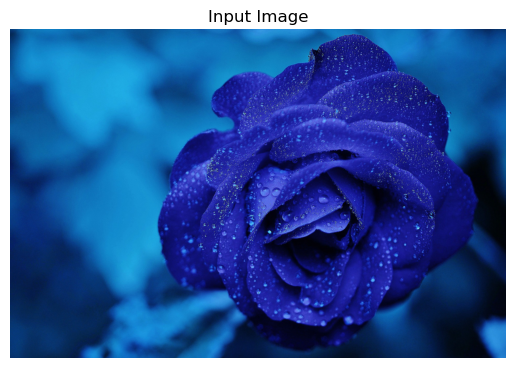

In [793]:
# Display the input image
plt.imshow(input_img)
plt.axis('off')
plt.title("Input Image");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


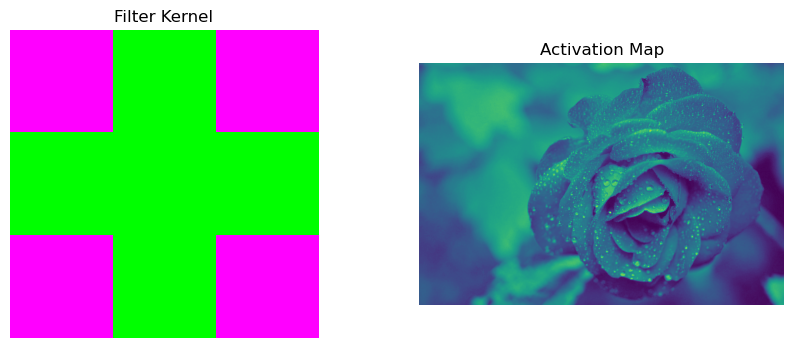

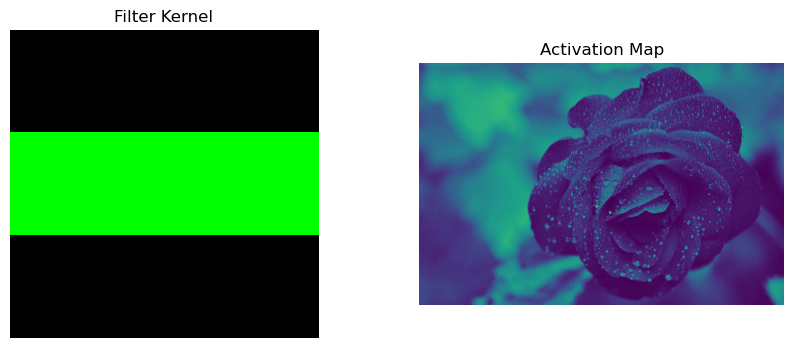

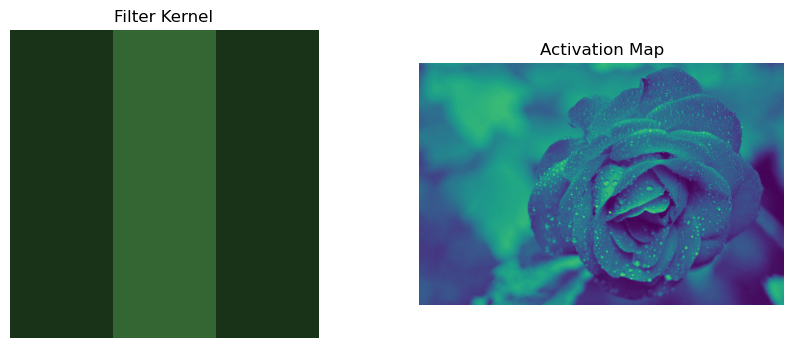

In [794]:
# Display the filter kernels and corresponding activation maps
num_filters = filter_kernels.shape[0]
for f in range(num_filters):
    fig = plt.figure(figsize=(16,4))
    
    fig.add_subplot(1, num_filters, 1)
    plt.imshow(filter_kernels[f])
    plt.axis('off')
    plt.title("Filter Kernel");
    
    fig.add_subplot(1, num_filters, 2)
    plt.imshow(activation_vol[:,:,f])
    plt.axis('off')
    plt.title("Activation Map");

## Question 4

**Pooling layer function:** It accepts as input the activation map volume, the pooling function,
stride, and generates a pooled output volume. Display the input and output volumes. A special
case for performing Global Average Pooling should also be provided

In [795]:
def pooling_layer(image, pool_fn=np.max, stride=1, GAP=False):
    # Get dimensions of input volume
    n_H, n_W, ch = image.shape
    
    # Calculate output dimensions
    n_H_out = int((n_H - 1) / stride) + 1
    n_W_out = int((n_W - 1) / stride) + 1
    
    # Initialize output activation volume
    output = np.zeros((n_H_out, n_W_out, ch))
        
    # Loop over output activation map
    for f in range(num_filters):
        for h in range(n_H_out):
            for w in range(n_W_out):
                # Find the corners of the current "slice" of the input volume
                vert_start = h * stride
                vert_end = vert_start + stride
                horiz_start = w * stride
                horiz_end = horiz_start + stride
                
                # Extract the slice of the input volume
                activation_slice = image[vert_start:vert_end, horiz_start:horiz_end, f]
                
                # Apply the pooling function to the slice
                output[h, w, f] = pool_fn(activation_slice)
                
        # Case for Global Average Pooling
    if GAP == True:
        gap_output = np.zeros(ch)
        for f in range(num_filters):
            gap_output[f] = np.mean(output[f])
        return gap_output
        
    return output

In [796]:
activation_vol.shape

(635, 959, 3)

In [797]:
num_filters = activation_vol.shape[-1]

In [798]:
pooled_map = pooling_layer(activation_vol, stride=4, GAP=False)
pooled_map.shape

(159, 240, 3)

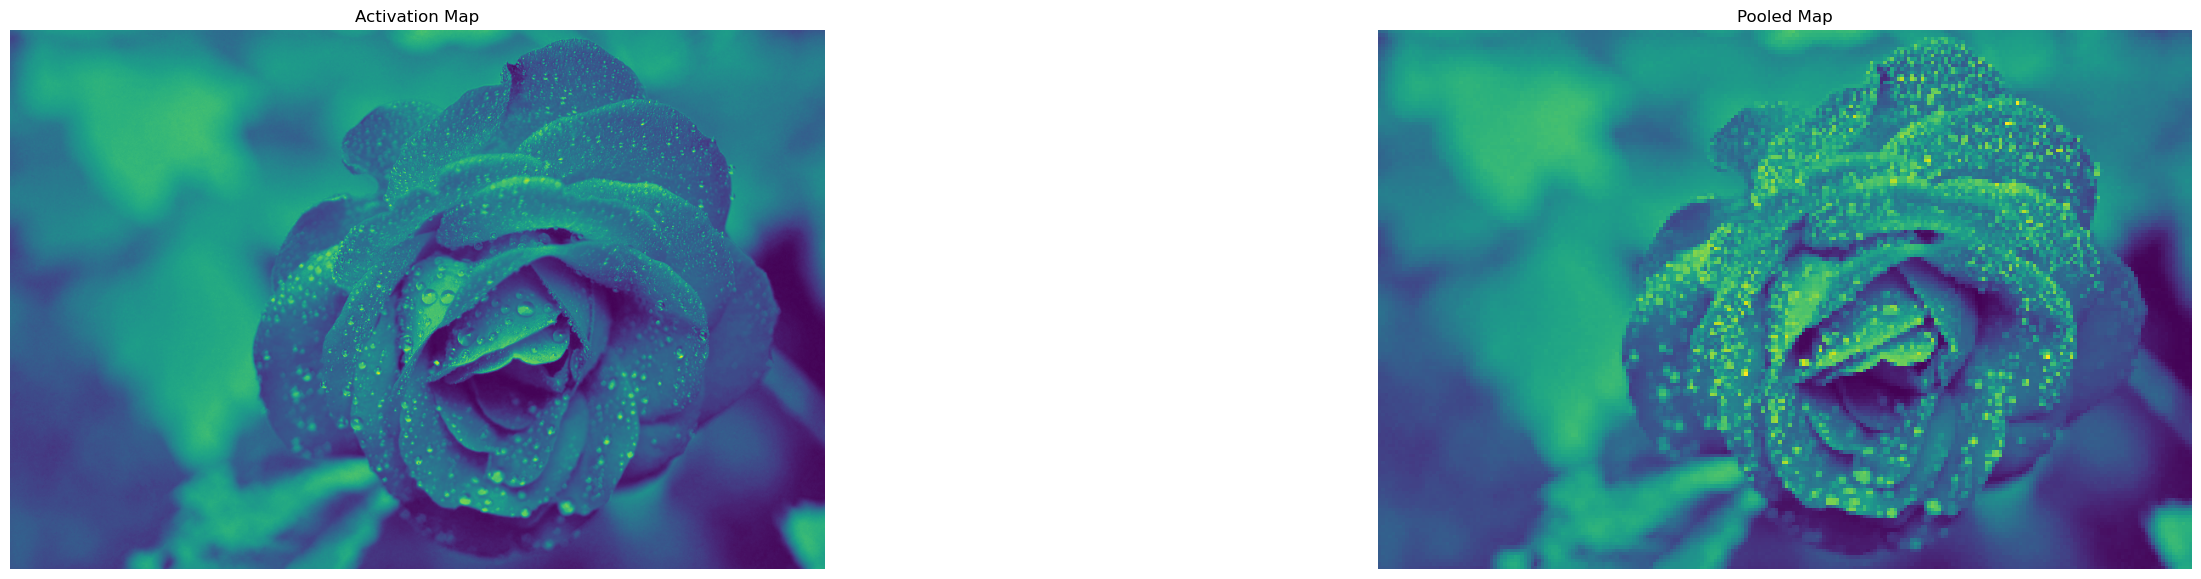

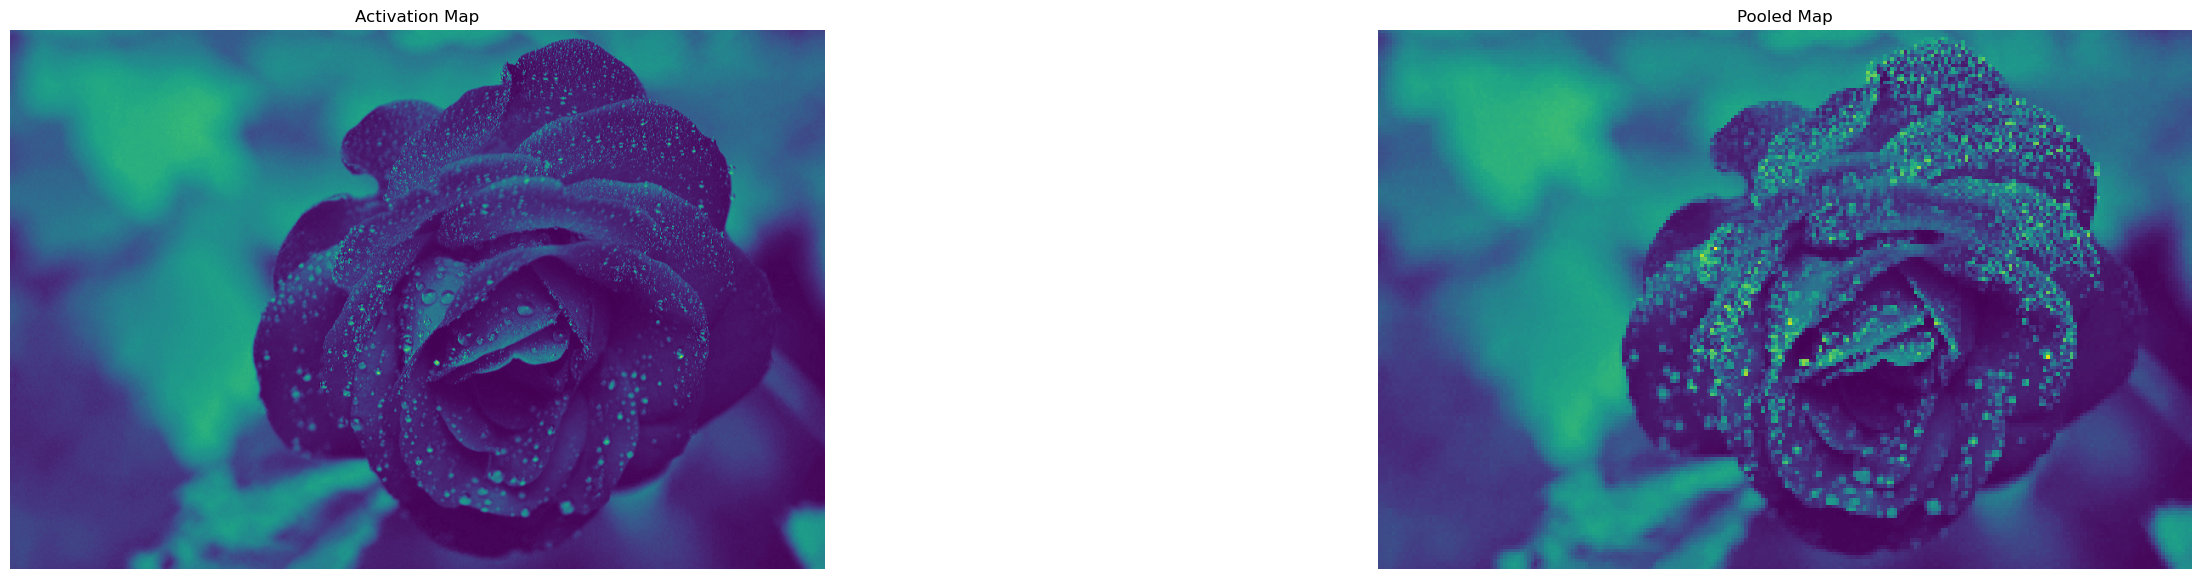

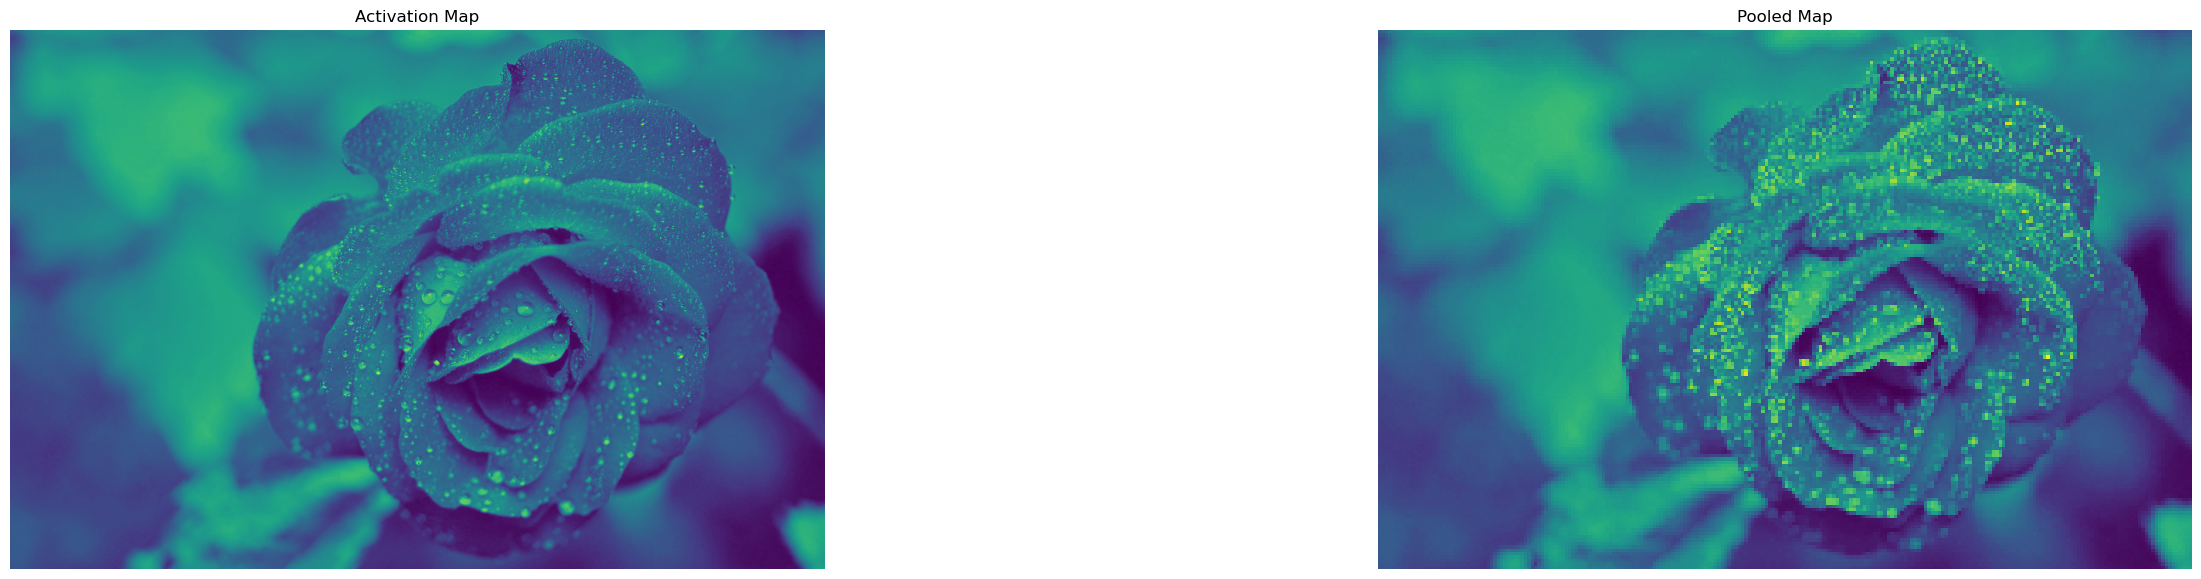

In [799]:
# Display input images and corresponding pooled outputs
for f in range(num_filters):
    fig = plt.figure(figsize=(50, 7))
    
    fig.add_subplot(1, num_filters, 1)
    plt.imshow(activation_vol[:,:,f])
    plt.axis('off')
    plt.title("Activation Map");
    
    fig.add_subplot(1, num_filters, 2)
    plt.imshow(pooled_map[:,:,f])
    plt.axis('off')
    plt.title("Pooled Map");

## Question 5

**Flattening (unraveling) function:** It accepts as input the activation map volume output by the
pooling layer and generates a vector of a specified size. It is important to note that this function
has a weight matrix associated with it whose size is chosen such that the input and desired output
sizes are matched.

In [800]:
def flatten(image):
    image = np.array(image)
    # Get the dimensions of the image
    ch, h, w = image.shape
    
    # Initialize flattened vector
    size = ch*h*w
    output = np.zeros(size)
    
    # Flatten image
    for C in range(ch):
        for H in range(h):
            for W in range(w):
                idx = C*h*w + H*w + W
                output[idx] = image[C, H, W]
    
    return output

In [801]:
pooled_map.shape

(159, 240, 3)

In [802]:
flattened_image = flatten(pooled_map)
flattened_image.shape

(114480,)

## Question 6

**Multilayer Perceptron (MLP) function:** It accepts as input a vector, the number of hidden
layers, the size of each hidden layer, the non-linear function, and the size of the output layer. This
function should generate an output vector of the specified size. Generate the output with and
without the softmax function applied to the output layer.

In [803]:
def MLP(input_vector, hidden_layers, hidden_layer_size, activation, output_size, apply_softmax=False):
    # Initialize weights and biases for hidden layers
    weights = []
    biases = []
    for i in range(hidden_layers):
        if i == 0:
            weights.append(np.random.randn(input_vector.shape[0], hidden_layer_size))
        else:
            weights.append(np.random.randn(hidden_layer_size, hidden_layer_size))
        biases.append(np.random.randn(hidden_layer_size, 1))
    
    # Initialize weights and biases for output layer
    weights.append(np.random.randn(hidden_layer_size, output_size))
    biases.append(np.random.randn(output_size, 1))

    # Forward pass
    vec = input_vector.reshape((input_vector.shape[0], 1))
    
    # Compute output for each hidden layer
    for i in range(hidden_layers):
        vec = np.dot(weights[i].T, vec) + biases[i]
        vec = activation(vec)
        
    # Compute output for output layer  
    output = np.dot(weights[-1].T, vec) + biases[-1]
    
    # Apply softmax if specified
    if apply_softmax == True:
        output = softmax(output)
    
    return output

## Question 7

**Feed-forward path:** Finally, use the functions you have written to implement a CNN with the
following architecture. The CNN must accept an image input and output a vector of appropriate
dimension. In other words, the function must effectively implement the feed-forward path in a
CNN.

• Input image of size 32 × 32 × 3. Use images from the CIFAR-10 dataset.

• Convolution layer with 16 kernels of size 3 × 3 spatial dimensions and sigmoid activation.

• Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.

• Convolution layer with 8 kernels of spatial size 3 × 3 and sigmoid activation.

• Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.

• A Global Average Pooling (GAP) layer.

• An MLP with one hidden layer (size same as input) that accepts as input the previous layer’s
output and maps it to 10 output nodes. Use sigmoid activation for the MLP (softmax in the
o/p layer).

Verify that your composition of function accepts and image input and outputs a vector.

In [804]:
# !pip install torchvision

In [805]:
from torchvision.datasets import CIFAR10

In [806]:
dataset = CIFAR10(root='data/', download=True)

In [807]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train

In [816]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [809]:
def FeedForwardCNN(image):
    # Convert image to array
    kernel_16 = generate_kernel((16,3,3,3))
    kernel_8 = generate_kernel((8,16,3,3))
    
    image = np.array(image)
    
    conv_layer1 = convolutional_layer(image, kernel_16, stride=1, padding=0, activation=sigmoid)
    max_pool1 = pooling_layer(conv_layer1, pool_fn=np.max, stride=2)
    conv_layer2 = convolutional_layer(max_pool1, kernel_8, stride=1, padding=0, activation=sigmoid)
    max_pool2 = pooling_layer(conv_layer2, pool_fn=np.max, stride=2, GAP=True)
    output = MLP(max_pool2, hidden_layers=1, hidden_layer_size=max_pool2.shape[0], activation=sigmoid, output_size=10, apply_softmax=True)
    
    return output

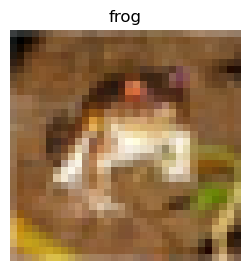

In [810]:
image, label = dataset[0]
plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis('off')
plt.title(f'{dataset.classes[label]}');

In [811]:
CNN = FeedForwardCNN(image)

C:\Users\relat\AppData\Local\Temp\ipykernel_26160\2994016198.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [812]:
CNN

array([[2.47594845e-04],
       [1.38127081e-03],
       [3.48418947e-02],
       [7.88741833e-01],
       [1.03688901e-01],
       [5.81047770e-03],
       [2.53173208e-02],
       [1.93081924e-03],
       [3.24806269e-02],
       [5.55926073e-03]])

## Question 8

## Part (a)

In [813]:
def extract_images(data):
    arr = [0]*10
    out = [0]*10
    
    for i in range(len(data)):
        x = dataset[i]
        if arr[x[1]] == 0:
            out[x[1]] = x
            arr[x[1]] = 1
        if sum(arr) == 10:
            return out

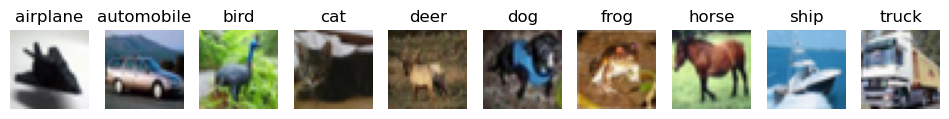

In [814]:
images = extract_images(dataset)
fig = plt.figure(figsize=(12,5))
for img, label in images:
    fig.add_subplot(1,10,label+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{dataset.classes[label]}") 

In [815]:
for img, label in images:
    output_vec = FeedForwardCNN(img)
    print(f"Output vector for {dataset.classes[label]}:\n {output_vec}")
    print()

C:\Users\relat\AppData\Local\Temp\ipykernel_26160\2994016198.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Output vector for airplane:
 [[0.04605873]
 [0.16298073]
 [0.0052766 ]
 [0.02345828]
 [0.02677904]
 [0.04496096]
 [0.03589387]
 [0.03573989]
 [0.04173331]
 [0.57711858]]

Output vector for automobile:
 [[0.00442398]
 [0.0043937 ]
 [0.00608547]
 [0.72545202]
 [0.03701929]
 [0.01151711]
 [0.06379871]
 [0.01275933]
 [0.01085988]
 [0.12369051]]

Output vector for bird:
 [[0.00645735]
 [0.12641952]
 [0.011535  ]
 [0.11451477]
 [0.04466281]
 [0.42321123]
 [0.11099536]
 [0.00462736]
 [0.00364752]
 [0.15392909]]

Output vector for cat:
 [[0.01672836]
 [0.02435065]
 [0.10043693]
 [0.01091114]
 [0.00331857]
 [0.01493307]
 [0.15563925]
 [0.10048853]
 [0.11013439]
 [0.46305912]]

Output vector for deer:
 [[0.01785915]
 [0.00858396]
 [0.0034605 ]
 [0.1679801 ]
 [0.19346935]
 [0.10021308]
 [0.39455001]
 [0.04361771]
 [0.01279958]
 [0.05746656]]

Output vector for dog:
 [[0.29386574]
 [0.00471134]
 [0.0053677 ]
 [0.21335379]
 [0.02673758]
 [0.10247692]
 [0.01202421]
 [0.33736224]
 [0.00188998]
 [0.00

## Part (b)

A randomly initialized network does not show any discriminability as the weights in the network are initially assigned random values that do not have any particular meaning. This means that the output of the network for any given input will be essentially random and uninformative, and not significantly different from random guessing.